In [1]:
# Physics modules
from metric import metric
from hybrid_eos import hybrid_eos

# Numpy and matplotlib
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init 
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import matplotlib.pyplot as plt

from data_utils import * 

In [2]:
use_fp64 = True  # Toggle this to switch precision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dtype = torch.float64 if use_fp64 else torch.float32

In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # Use 'relu' for SiLU
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize biases to 0


class C2PNet(nn.Module):
    def __init__(self, dtype=torch.float64):
        super(C2PNet, self).__init__()
        self.fc1 = nn.Linear(3, 64, dtype=dtype)
        self.fc2 = nn.Linear(64, 128, dtype=dtype)
        self.fc3 = nn.Linear(128, 128, dtype=dtype)
        self.fc4 = nn.Linear(128, 64, dtype=dtype)
        self.fc5 = nn.Linear(64+3, 1, dtype=dtype)  # Single output z = W v
        self.activation = nn.SiLU()  # Smooth activation
        self.output = nn.ReLU() # Ensure positivity of z
        self.apply(init_weights)
        
    def forward(self, x):
        identity = x  # Residual connection using one input component
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = torch.cat([x, identity], dim=1)
        x = self.output(self.fc5(x))   # Residual connection
        return x

In [4]:
class C2P_Dataset(TensorDataset):
    
    def __init__(self,C,Z,normalize_data=True):
        
        self.C = C.to(dtype)
        self.Z = Z.to(dtype)
        
        if normalize_data:
            self.normalize()
        
    def normalize(self):
        self.C_max = torch.max(self.C, dim=0, keepdim=True)[0]
        self.C_min = torch.min(self.C, dim=0, keepdim=True)[0]
        self.C = (self.C - self.C_min)/(self.C_max-self.C_min)
        self.Z_max = torch.max(self.Z, dim=0, keepdim=True)[0]
        self.Z_min = torch.min(self.Z, dim=0, keepdim=True)[0]
        self.Z = (self.Z - self.Z_min)/(self.Z_max-self.Z_min)
        
    def __len__(self):
        return self.C.shape[0]
    
    def __getitem__(self,idx):
        return self.C[idx,:], self.Z[idx,:]

In [5]:
# Minkowski metric 
eta = metric(
torch.eye(3,device=device), torch.zeros(3,device=device), torch.ones(1,device=device)
)
# Gamma = 2 EOS with ideal gas thermal contrib 
eos = hybrid_eos(100,2,1.8)

In [6]:
C_max = torch.load("C_max.pt").to(device)
C_min = torch.load("C_min.pt").to(device)
Z_max = torch.load("Z_max.pt").to(device)
Z_min = torch.load("Z_min.pt").to(device)

/tmp/ipykernel_3317249/3688507672.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  C_max = torch.load("C_max.pt").to(device)
/tmp/ipykernel_3317249/3688507672.py:2: Futur

In [7]:
modelfile = "model_11.pt"

net = C2PNet(dtype=dtype).to(device)
net.load_state_dict(torch.load(modelfile,weights_only=True))

net.eval() 

C2PNet(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=67, out_features=1, bias=True)
  (activation): SiLU()
  (output): ReLU()
)

In [8]:
def log_cosh_loss(y_true, y_pred):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def compute_loss(model, C,C_min, C_max,  Z,Z_min,Z_max, eos):
    '''
    Eq (C3) of https://arxiv.org/pdf/1306.4953.pdf
    '''
    dtype = torch.float64
    Z_pred = model(C) # Data is normalized inside dataset constructor 
    C_real = C * (C_max - C_min) + C_min
    Z_real = Z * (Z_max - Z_min) + Z_min
    htilde = h__z(Z_real,C_real,eos)
    MSEr = log_cosh_loss(Z_real,C_real[:,2].view(-1,1)/htilde).to(dtype)
 
    return log_cosh_loss(Z_pred,Z).to(dtype) + MSEr 

In [9]:
class c2p:
    
    def __init__(self,model,eos,C_min,C_max,Z_min,Z_max):
        self.model = model
        self.C_min = C_min
        self.C_max = C_max
        self.Z_min = Z_min
        self.Z_max = Z_max 
        self.eos = eos 
    
    def invert(self,C):
        with torch.no_grad():
            Z = self.model((C-self.C_min)/(self.C_max-self.C_min))
        Z = Z * (self.Z_max-self.Z_min) + self.Z_min
        
        rho = rho__z(Z,C)
        W   = W__z(Z)
        eps = eps__z(Z,C)
        press = self.eos.press__eps_rho(eps,rho)
        return rho,eps,press,W 

In [10]:
# Get W, rho and T 
Wmin = 1.2 
Wmax = 1.8 
lrhomin = -12
lrhomax = -2.8
N = 100
W   = torch.linspace(Wmin,Wmax,N,device=device)
rho = 10**(torch.linspace(lrhomin,lrhomax,N,device=device))

# Meshgrid
rhom, Wm = torch.meshgrid(rho,W, indexing='ij')

# Flatten
rho = rhom.flatten()
W = Wm.flatten() 

# Temperature (0)
T   = torch.zeros_like(rho,device=device)

# Call EOS to get press and eps 
press,eps = eos.press_eps__temp_rho(T,rho)
# Compute z 
Z = torch.sqrt(1 - 1/W**2) * W 

# Compute conserved vars 
sqrtg = eta.sqrtg 
u0 = W / sqrtg 
dens = sqrtg * W * rho 

rho0_h = rho * ( 1 + eps ) + press 
g4uptt = - 1/eta.alp**2 
Tuptt = rho0_h * u0**2 + press * g4uptt 
tau = eta.alp**2 * sqrtg * Tuptt - dens 

S = torch.sqrt((W**2-1)) * rho0_h * W
# Assemble output 
C = torch.cat((dens.view(-1,1)/eta.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1).to(dtype)

RHO = rhom.view(N,N).cpu().detach().numpy()
WW  = Wm.view(N,N).cpu().detach().numpy()


In [11]:
inverter = c2p(net,eos,C_min,C_max,Z_min,Z_max)
rho_pred,eps_pred,press_pred,W_pred = inverter.invert(C)
rho_res = (torch.abs(rho_pred-rho.view(-1,1))/rho.view(-1,1)).view(N,N).cpu().detach().numpy()
eps_res = (torch.abs(eps_pred-eps.view(-1,1))/eps.view(-1,1)).view(N,N).cpu().detach().numpy()
press_res = (torch.abs(press_pred-press.view(-1,1))/press.view(-1,1)).view(N,N).cpu().detach().numpy()
W_res = (torch.abs(W_pred-W.view(-1,1))/W.view(-1,1)).view(N,N).cpu().detach().numpy()
residual = ( rho_res + eps_res + press_res + W_res ) / 4 

/mnt/rafast/musolino/pyenv/numrel/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


False


/tmp/ipykernel_3317249/1194026467.py:7: RuntimeWarning: divide by zero encountered in log10
  a = ax.pcolormesh(RHO,WW,np.log10(np.abs(Z.view(N,N).detach().cpu().numpy()-Zp)))


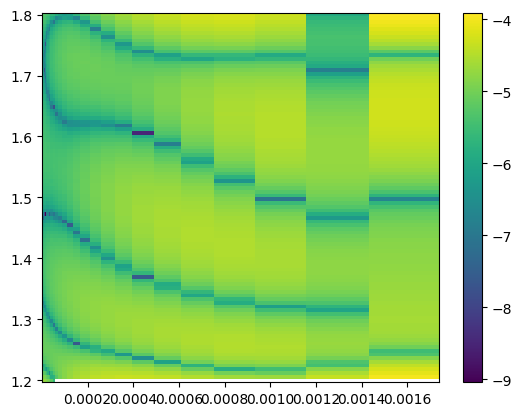

In [15]:
with torch.no_grad():
    Zp = net((C-C_min)/(C_max-C_min))
Zp = Zp * (Z_max-Z_min) + Z_min
Zp = Zp.view(N,N).detach().cpu().numpy()
fig, ax = plt.subplots() 
print(np.any(np.isnan(Zp)))
a = ax.pcolormesh(RHO,WW,np.log10(np.abs(Z.view(N,N).detach().cpu().numpy()-Zp)))
plt.colorbar(a)

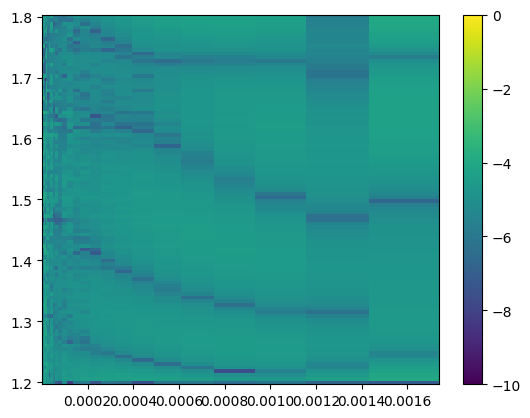

In [13]:
fig, ax = plt.subplots() 
#print(np.any(np.isnan(Zp)))
a = ax.pcolormesh(RHO,WW,np.log10(np.abs(press_res)), vmin=-10,vmax=0)
plt.colorbar(a)

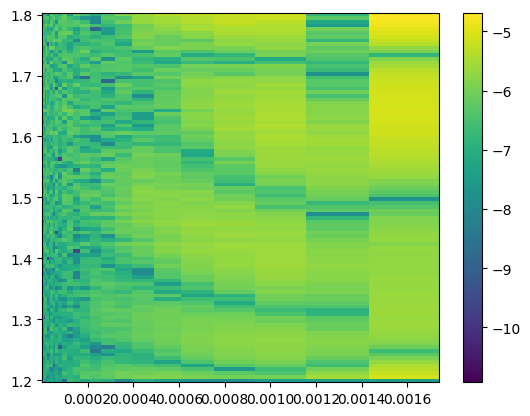

In [14]:
with torch.no_grad():
    Zp = net((C-C_min)/(C_max-C_min))
Zp = Zp * (Z_max-Z_min) + Z_min
func = C[:,2].view(-1,1)/h__z(Zp,C,eos)
fig, ax = plt.subplots() 
a = ax.pcolormesh(RHO,WW,np.log10(np.abs(func.view(N,N).cpu().detach().numpy()-Z.view(N,N).cpu().detach().numpy())))
plt.colorbar(a)

/tmp/ipykernel_3099493/2025838654.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  a = ax.pcolormesh(SS,TT,np.log10(np.abs(func.view(N,N).cpu().detach().numpy())))


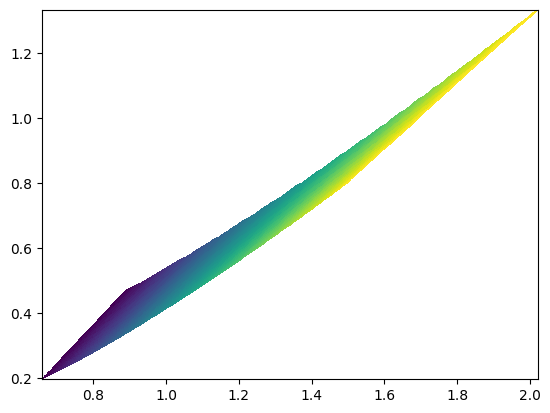

In [ ]:
fig, ax = plt.subplots() 
DD = C[:,0].view(N,N).detach().cpu().numpy() 
TT = C[:,1].view(N,N).detach().cpu().numpy()
SS = C[:,2].view(N,N).detach().cpu().numpy()
a = ax.pcolormesh(SS,TT,np.log10(np.abs(func.view(N,N).cpu().detach().numpy())))